In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Initial Reqs

In [ ]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import math
from itertools import combinations_with_replacement
import pickle
from IPython.display import display
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth=100
from natsort import natsorted
import seaborn as sns
import scipy.stats as stats 
from collections import Counter
from itertools import groupby
from operator import itemgetter
from itertools import combinations
import time
import datetime
import choix
import plotly.graph_objects as go
from tqdm import tqdm

# Functions

In [ ]:
def radarPlotDF(countsdf,maxpt,title,**kwargs):
    """
    makes a radar plot from a dataframe with the first two columns being
    used as 'pre' and 'post

    countssdf: a 2 column dataframe with counts
    maxpt: how to scale

    optional-
    colorcode: put color code or not? 'on' if yes.
    """
    colorcode=kwargs.get('colorcode',None)
    #set up colors
    hues=np.linspace(0,1,16,endpoint=False)
    hues=['%1.2f' % i for i in hues]
    hues=[float(i) for i in hues]
    colors = plt.cm.hsv(hues)
    # Compute pie slices
    N = 16
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    radii = np.repeat(1,N)
    width = np.repeat(0.25,N)

    #set up data
    counts_df1=countsdf.iloc[:,0]
    counts_df2=countsdf.iloc[:,1]
    categories1=[str(i) for i in counts_df1.index]#cars
    N = len(categories1)
    #cars
    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    #this doesn't change for all. all have 16 data points
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories1, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([i for i in np.arange(0,maxpt)],[],color="black", size=5)
    plt.ylim(0,maxpt)
    # Plot data
    ax.plot(angles, values1, linewidth=1, linestyle='solid')
    ax.plot(angles, values2, linewidth=1, linestyle='solid')
    # Fill area
    ax.fill(angles, values1, 'b', alpha=0.1)
    ax.fill(angles, values2, 'r', alpha=0.1)
    if colorcode=='on':
      bars = ax.bar(theta, radii, width=width, bottom=15, color=colors)
    ax.legend(['Pre','Post'])
    plt.title(title)
   
def interactiveRadar(countsDF,subname,category):
    counts_df1=countsDF.iloc[:,0]#pre
    counts_df2=countsDF.iloc[:,1]#post
    counts_df3=countsDF.iloc[:,2]#pre
    categories1=[str(i)[0:7] for i in counts_df1.index]#shirts
    N = len(categories1)

    values1=[i for i in counts_df1.values]
    values1 += values1[:1] #makes it circular
    values2=[i for i in counts_df2.values]
    values2 += values2[:1] #makes it circular
    values3=[i for i in counts_df3.values]
    values3 += values3[:1] #makes it circular


    fig = go.Figure()
    
    #plot pre
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
          r=values1,
          theta=categories1,
          fill='toself',
          name='Pre'
    ))
    #plot post
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
          r=values2,
          theta=categories1,
          fill='toself',
          name='Post '
    ))
    #plot follow-up
    fig.add_trace(go.Scatterpolar(
        opacity=0.75,
        r=values3,
        theta=categories1,
        fill='toself',
        name='3 Day '
    ))

    fig.update_layout(
    title=subname+' '+ category,
      polar=dict(
        radialaxis=dict(
          visible=True,
            showline=False,
              range=[0, 16]
        )),
      showlegend=True
    )

    fig.show()

def getPscore(data,score):
    pscore=stats.percentileofscore(data,score,kind='mean')
    return(pscore/100)

def colorcode(value):
  """
  Colors elements in a dateframe
  green if over 0.95
  """
  if value > 0.99 or value < 0.01:
    color = 'green'
  else:
    color = 'black'

  return 'color: %s' % color

from decimal import Decimal # Decimal used for extra precision

def coordinates_of_triangle_given_SSS(a, b, c):
    """a, b and c are lengths of the sides of a triangle
    https://math.stackexchange.com/questions/2480560/computing-coordinates-of-vertices-in-a-sss-triangle
    """

    A = (0, 0) # coordinates of vertex A

    B = (c, 0) # coordinates of vertex B

    C_x = b * (b**2 + c**2 - a**2) / (2 * b * c)
    C_y = Decimal(b**2 - C_x**2).sqrt() # square root

    C = (float(C_x), float(C_y)) # coordinates of vertex C

    # print
    vertices = np.array([A, B, C,A])
    return(vertices)

# Load Subjects

In [ ]:
#subject clas for loading
class Subject():
    def __init__(self,subname):
        self.subname=subname
#load
os.chdir(r"C:\Users\al33m\Google Drive\GU Neuroaesthetics Lab\AestheticStability\SubDicts\first_visit")
subs={}
for i in ['sub'+str(i) for i in np.arange(1,12)]:
    print(i)
    with open(i+'.pkl', 'rb') as input:
        subs[i] = pickle.load(input)

In [ ]:
class FUPSubject():
    """
    had to create a new class for followup because prolific Id's are not aligned, future iteration should just be one class
    """
    def __init__(self,subname):
        self.subname=subname
#load
os.chdir(r"C:\Users\al33m\Google Drive\GU Neuroaesthetics Lab\AestheticStability\SubDicts\follow_up")
FUPsubs={}
for i in ['sub'+str(i) for i in [2,3,5,6,7,8,9,10,11]]:
    print(i)
    with open(i+'.pkl', 'rb') as input:
        FUPsubs[i] = pickle.load(input)

# General Subject Data

I am saving subject data along with other measures to be shared in the future in a box folder entitled 'forNG'. Below is what the folder structure looks like

In [ ]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [ ]:
from pathlib import Path

class DisplayablePath(object):
    display_filename_prefix_middle = '├──'
    display_filename_prefix_last = '└──'
    display_parent_prefix_middle = '    '
    display_parent_prefix_last = '│   '

    def __init__(self, path, parent_path, is_last):
        self.path = Path(str(path))
        self.parent = parent_path
        self.is_last = is_last
        if self.parent:
            self.depth = self.parent.depth + 1
        else:
            self.depth = 0

    @property
    def displayname(self):
        if self.path.is_dir():
            return self.path.name + '/'
        return self.path.name

    @classmethod
    def make_tree(cls, root, parent=None, is_last=False, criteria=None):
        root = Path(str(root))
        criteria = criteria or cls._default_criteria

        displayable_root = cls(root, parent, is_last)
        yield displayable_root

        children = sorted(list(path
                               for path in root.iterdir()
                               if criteria(path)),
                          key=lambda s: str(s).lower())
        count = 1
        for path in children:
            is_last = count == len(children)
            if path.is_dir():
                yield from cls.make_tree(path,
                                         parent=displayable_root,
                                         is_last=is_last,
                                         criteria=criteria)
            else:
                yield cls(path, displayable_root, is_last)
            count += 1

    @classmethod
    def _default_criteria(cls, path):
        return True

    @property
    def displayname(self):
        if self.path.is_dir():
            return self.path.name + '/'
        return self.path.name

    def displayable(self):
        if self.parent is None:
            return self.displayname

        _filename_prefix = (self.display_filename_prefix_last
                            if self.is_last
                            else self.display_filename_prefix_middle)

        parts = ['{!s} {!s}'.format(_filename_prefix,
                                    self.displayname)]

        parent = self.parent
        while parent and parent.parent is not None:
            parts.append(self.display_parent_prefix_middle
                         if parent.is_last
                         else self.display_parent_prefix_last)
            parent = parent.parent

        return ''.join(reversed(parts))

In [ ]:
paths = DisplayablePath.make_tree(Path(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data"))
for path in paths:
    print(path.displayable())

**CompMat** are the actual comparison matrices of the runs. Each subject and category has two, PRE/POST. Below is an example of one. Here, the convention is that the value represents the score of the column. Thus, 'Shirt1.png' won all of its competitions.

In [ ]:
subs['sub1'].pre_ShirtsComparisonMat_df

In [ ]:
# save shirts A and B
for i in subs.keys():
    subs[i].pre_ShirtsComparisonMat_df.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CompMat\Shirts\A/"
                                              +i+'A_ShirtsCompMat.csv',index=False)
    subs[i].post_ShirtsComparisonMat_df.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CompMat\Shirts\B/"
                                              +i+'B_ShirtsCompMat.csv',index=False)
    subs[i].pre_CarsComparisonMat_df.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CompMat\Cars\A/"
                                              +i+'A_CarsCompMat.csv',index=False)
    subs[i].post_CarsComparisonMat_df.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CompMat\Cars\B/"
                                              +i+'B_CarsCompMat.csv',index=False)

In [ ]:
for i in FUPsubs.keys():
    FUPsubs[i].FUPShirtsComparisonMat.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CompMat\Shirts\C/"+
                                             i+"C_ShirtsCompMat.csv",index=False)
    FUPsubs[i].FUPCarsComparisonMat.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CompMat\Cars\C/"+
                                             i+"C_CarsCompMat.csv",index=False)

**CountsTable** is the frequency of counts for each item, it also has the difference between counts and rankings, for example

In [ ]:
subs['sub1'].ShirtsCounts

In [ ]:
#AB
for i in subs.keys():
    subs[i].ShirtsCounts.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\AB\Shirts/"+
                               i+"AB_ShirtsCounts.csv",index=False)
    subs[i].CarsCounts.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\AB\Cars/"+
                               i+"AB_CarsCounts.csv",index=False)

In [ ]:
    FUPsubs[i].CarsCounts.iloc[:,np.r_[0,2,3,5,7,9]].to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\AC\Cars/"+i+"AC_CarsCounts.csv",index=False)#AC
    FUPsubs[i].CarsCounts.iloc[:,np.r_[1,2,4,6,7,8]].to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\BC\Cars/"+i+"BC_CarsCounts.csv",index=False) #BC
    

In [ ]:
for i in FUPsubs.keys():
    FUPsubs[i].ShirtsCounts.iloc[:,np.r_[0,2,3,5,7,9]].to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\AC\Shirts/"+i+"AC_ShirtsCounts.csv",index=False)#AC
    FUPsubs[i].ShirtsCounts.iloc[:,np.r_[1,2,4,6,7,8]].to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\BC\Shirts/"+i+"BC_ShirtsCounts.csv",index=False) #BC
    
    FUPsubs[i].CarsCounts.iloc[:,np.r_[0,2,3,5,7,9]].to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\AC\Cars/"+i+"AC_CarsCounts.csv",index=False)#AC
    FUPsubs[i].CarsCounts.iloc[:,np.r_[1,2,4,6,7,8]].to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\CountsTable\BC\Cars/"+i+"BC_CarsCounts.csv",index=False) #BC
    

# Distance Measures

## Kendall Distance

These data are saved in 

Subject_Data──KD──Shirts

### Shirts

In [ ]:
for i in FUPsubs.keys():
    subs[i].AB_ShirtsKendallDist=choix.kendalltau_dist(subs[i].ShirtsParDF.iloc[:,0],subs[i].ShirtsParDF.iloc[:,1])/120
    FUPsubs[i].AC_ShirtsKendallDist=choix.kendalltau_dist(FUPsubs[i].ShirtsParDF.iloc[:,0],FUPsubs[i].ShirtsParDF.iloc[:,2])/120
    FUPsubs[i].BC_ShirtsKendallDist=choix.kendalltau_dist(FUPsubs[i].ShirtsParDF.iloc[:,1],FUPsubs[i].ShirtsParDF.iloc[:,2])/120

#### This table of 27 normalized KD values is being saved

In [50]:
ShirtsKD=pd.DataFrame({'subs':[i for i in FUPsubs.keys()],
             'AB':[subs[i].AB_ShirtsKendallDist for i in FUPsubs.keys()],
             'BC':[FUPsubs[i].BC_ShirtsKendallDist for i in FUPsubs.keys()],
             'AC':[FUPsubs[i].AC_ShirtsKendallDist for i in FUPsubs.keys()]})
ShirtsKD

,subs,AB,BC,AC
0,sub2,0.283333,0.283333,0.200000
1,sub3,0.116667,0.266667,0.250000
2,sub5,0.316667,0.500000,0.316667
3,sub6,0.191667,0.241667,0.266667
4,sub7,0.225000,0.150000,0.358333
5,sub8,0.366667,0.325000,0.308333
6,sub9,0.116667,0.091667,0.158333
7,sub10,0.175000,0.183333,0.258333
8,sub11,0.183333,0.125000,0.208333


#### Histogram

Text(0, 0.5, 'Frequency')

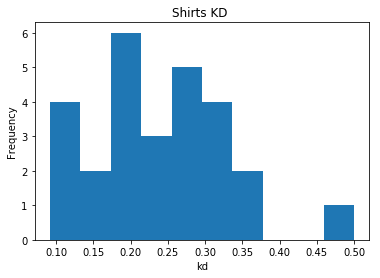

In [51]:
plt.hist(ShirtsKD.iloc[:,1:].values.flatten())
plt.title('Shirts KD ')
plt.xlabel('kd')
plt.ylabel('Frequency')

In [ ]:
ShirtsKD.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\KD\Shirts\ShirtsKD.csv",index=False)

#### Visualizing with an ABC triangle A=(0,0)

In [ ]:
def coordinates_of_triangle_given_SSS(a, b, c):
    """a, b and c are lengths of the sides of a triangle
    https://math.stackexchange.com/questions/2480560/computing-coordinates-of-vertices-in-a-sss-triangle
    """

    A = (0, 0) # coordinates of vertex A

    B = (c, 0) # coordinates of vertex B

    C_x = b * (b**2 + c**2 - a**2) / (2 * b * c)
    C_y = Decimal(b**2 - C_x**2).sqrt() # square root

    C = (float(C_x), float(C_y)) # coordinates of vertex C

    # print
    vertices = np.array([A, B, C, A])
    return(vertices)

In [ ]:
def plotTriangle(vec):
    mylabels=['A','C','B','A']
    vertices=coordinates_of_triangle_given_SSS(vec[1],vec[0],vec[2])
#     vertices=pd.DataFrame(vertices,columns=['xval','yval'])
#     plt.plot( 'xval', 'yval', data=vertices, linestyle='-', marker='o')
    x_coords=vertices[:,0]
    y_coords=vertices[:,1]
    for i,type in enumerate(mylabels):
        x = x_coords[i]
        y = y_coords[i]
        plt.scatter(x, y, marker='o',color='black')
        plt.text(x+0.003, y+0.003,type, fontsize=9)
    plt.plot(x_coords,y_coords)


In [ ]:
for i in np.arange(9):
    plotTriangle(ShirtsKD.loc[i][1:].values)
plt.legend([i for i in FUPsubs.keys()])

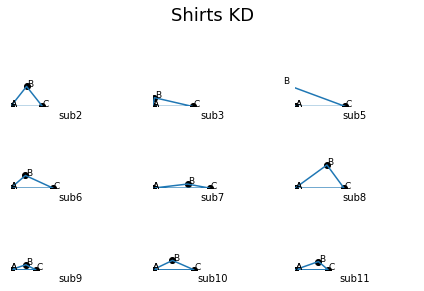

In [52]:
fig,ax=plt.subplots()
fig.subplots_adjust(hspace=1, wspace=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plotTriangle(ShirtsKD.loc[i-1][1:].values)
    plt.xlabel([i for i in FUPsubs.keys()][i-1])
#     plt.xlabel('B')
#     plt.ylabel('C',rotation=0)
    plt.ylim(0,0.75)
    plt.xlim(0,0.75)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    plt.tick_params(axis='both', which='both', 
                    bottom=False, 
                    top=False, 
                    labelbottom=False, 
                    right=False, 
                    left=False, 
                    labelleft=False)
st=fig.suptitle('Shirts KD',fontsize=18)
fig.tight_layout()
# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)


### Cars

In [53]:
for i in FUPsubs.keys():
    subs[i].AB_CarsKendallDist=choix.kendalltau_dist(subs[i].CarsParDF.iloc[:,0],subs[i].CarsParDF.iloc[:,1])/120
    FUPsubs[i].AC_CarsKendallDist=choix.kendalltau_dist(FUPsubs[i].CarsParDF.iloc[:,0],FUPsubs[i].CarsParDF.iloc[:,2])/120
    FUPsubs[i].BC_CarsKendallDist=choix.kendalltau_dist(FUPsubs[i].CarsParDF.iloc[:,1],FUPsubs[i].CarsParDF.iloc[:,2])/120

These data are saved in 

Subject_Data──KD──Cars

In [54]:
CarsKD=pd.DataFrame({'subs':[i for i in FUPsubs.keys()],
             'AB':[subs[i].AB_CarsKendallDist for i in FUPsubs.keys()],
             'BC':[FUPsubs[i].BC_CarsKendallDist for i in FUPsubs.keys()],
             'AC':[FUPsubs[i].AC_CarsKendallDist for i in FUPsubs.keys()]})
CarsKD

,subs,AB,BC,AC
0,sub2,0.191667,0.183333,0.125000
1,sub3,0.100000,0.116667,0.100000
2,sub5,0.550000,0.691667,0.575000
3,sub6,0.300000,0.308333,0.291667
4,sub7,0.141667,0.158333,0.200000
5,sub8,0.158333,0.225000,0.183333
6,sub9,0.091667,0.125000,0.100000
7,sub10,0.058333,0.183333,0.158333
8,sub11,0.141667,0.141667,0.100000


#### Histogram

Text(0, 0.5, 'Frequency')

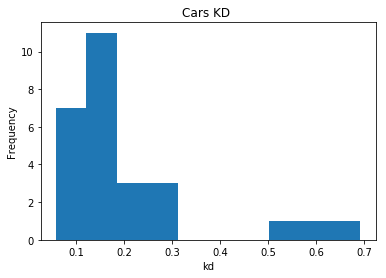

In [55]:
plt.hist(CarsKD.iloc[:,1:].values.flatten())
plt.title('Cars KD ')
plt.xlabel('kd')
plt.ylabel('Frequency')

In [ ]:
CarsKD.to_csv(r"C:\Users\al33m\Box Sync\Grzywacz Lab\Experiment\forNG\Subject_Data\KD\Cars\CarsKD.csv",index=False)

#### Visualizing with an ABC triangle A=(0,0)

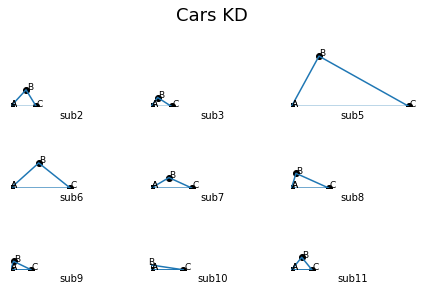

In [56]:
fig,ax=plt.subplots()
fig.subplots_adjust(hspace=1, wspace=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plotTriangle(CarsKD.loc[i-1][1:].values)
    plt.xlabel([i for i in FUPsubs.keys()][i-1])
#     plt.xlabel('B')
#     plt.ylabel('C',rotation=0)
    plt.ylim(0,0.6)
    plt.xlim(0,0.6)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')

    plt.tick_params(axis='both', which='both', 
                    bottom=False, 
                    top=False, 
                    labelbottom=False, 
                    right=False, 
                    left=False, 
                    labelleft=False)
st=fig.suptitle('Cars KD',fontsize=18)
fig.tight_layout()
# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)
